In [1]:
#Imports
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### 1. (40pts) Define functions

In [2]:

# One hot encode the labels
def one_hot_encode(y):
    enc = pd.get_dummies(y)
    return np.matrix(enc)


# Get the cost of iteration
def get_cost(y, y_pred):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y))
    return cost
    

#Get the accuracy of the results
def get_accuracy(y, y_pred):
    y = tf.nn.softmax(y)
    y_pred = tf.nn.softmax(y_pred)
    labels_equal = tf.equal(y, y_pred)
    accuracy = tf.reduce_mean(tf.cast(labels_equal, 'float'))
    return accuracy

# Initialize the hidden layer and output layer dimensions and apply activations on them
def initialize_deep_net(X, inputLayerSize, hiddenLayerSizes, outputLayerSize, keep_prob):
    
    # Xavier Weight Initialization
    hidden_layer_1 = {'W': tf.get_variable('W1', [inputLayerSize, hiddenLayerSizes[0]], initializer=tf.contrib.layers.xavier_initializer(seed = 1)),
                       'b': tf.get_variable('b1', [hiddenLayerSizes[0]],dtype=tf.float32, initializer=tf.zeros_initializer())}
    
    hidden_layer_2 = {'W':tf.get_variable('W2', [hiddenLayerSizes[0], hiddenLayerSizes[1]], initializer=tf.contrib.layers.xavier_initializer(seed = 1)),
                       'b':tf.get_variable('b2', [hiddenLayerSizes[1]],dtype=tf.float32, initializer=tf.zeros_initializer())}
    
    output_layer = {'W':tf.get_variable('W3', [hiddenLayerSizes[1], outputLayerSize], initializer=tf.contrib.layers.xavier_initializer(seed = 1)),
                       'b':tf.get_variable('b3', [outputLayerSize],dtype=tf.float32, initializer=tf.zeros_initializer())}
    
    return hidden_layer_1, hidden_layer_2, output_layer

def forward_propagation(X, inputLayerSize, hiddenLayerSizes, outputLayerSize, keep_prob):
    # Initialize the parameters
    hidden_layer_1, hidden_layer_2, output_layer = initialize_deep_net(X, inputLayerSize, 
                                                                hiddenLayerSizes, outputLayerSize, keep_prob)
    
    layer1 = tf.add(tf.matmul(tf.cast(X, tf.float32),hidden_layer_1['W']), hidden_layer_1['b'])
    layer1 = tf.nn.relu(layer1) # Relu on 1st Hidden Layer
    layer1_dropout = tf.nn.dropout(layer1, keep_prob, seed=2) # Drop-out Regularizarion
    
    
    layer2 = tf.add(tf.matmul(layer1_dropout,hidden_layer_2['W']), hidden_layer_2['b'])
    layer2 = tf.nn.relu(layer2) # Relu on 2nd Hidden Layer
    layer2_dropout = tf.nn.dropout(layer2, keep_prob, seed=2) # Drop-out Regularizarion

    output = tf.matmul(layer2_dropout,output_layer['W']) + output_layer['b']
    output = tf.nn.sigmoid(output) # Sigmoid on Output Layer
    return output

def plotCostHistory(cost_history):
     plt.plot(cost_history)
     plt.ylabel('Cost');
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations')
     plt.show()
        
def plot_accuracies_with_keep_prob(cache, label):
    accuracy = cache['accuracy']
    keep_prob = cache['keep_prob']
    plt.ylabel('Accuracy')
    plt.xlabel('Keep Probability')
    plt.title('Train and Test Accuracy Progression with increasing Keep Probablity')
    ax = plt.gca()
    ax.plot(keep_prob, accuracy, label=label)
    plt.legend()
    

### 2. Split data

In [3]:
# Reading the training data
data_train = pd.read_csv('ex4_train.csv', sep=",", encoding='utf-8', header='infer')
df_train = data_train.drop('Unnamed: 0',axis=1)

y_train = df_train['y']
X_train = df_train.drop(['y'], axis=1)

X_train_mat = np.matrix(X_train)

25    7
Name: y, dtype: int64


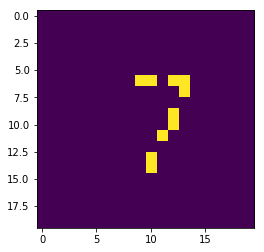

In [4]:
# Reading the test data
data_test = pd.read_csv('ex4_test.csv', sep=",", encoding='utf-8', header='infer')
df_test = data_test.drop('Unnamed: 0',axis=1)
m = df_test.shape[0]

y_test = df_test['y']
X_test = df_test.drop(['y'], axis=1)
X_test_mat = np.matrix(X_test)

# Plot the selected pixel
num = 25
pixels = np.array(X_test[num:num+1], dtype='uint8')
print(y_test[num:num+1])
pixels = pixels.reshape((20, 20)).T
plt.imshow(pixels)
plt.show()

### 3. Define number of neurons in each layer

In [5]:
inputLayerSize = X_train.shape[1]
hiddenLayers = 2
hiddenLayerSizes = [400,125]
outputLayerSize = 10

# One hot encode the labels
y_train_mat = one_hot_encode(y_train)
y_test_mat = one_hot_encode(y_test)

### 4. (30pts) Neural Network model with 2 hidden layers

In [6]:
def train_deep_neural_net(epochs, X_train, y_train, X_test, y_test, learning_rate, keep_prob):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, [None, X_train.shape[1]])
    y = tf.placeholder(tf.float32)
    y_pred = forward_propagation(x, inputLayerSize, hiddenLayerSizes, outputLayerSize, keep_prob)
    cost = get_cost(y, y_pred)
    # The AdamOptimizer is used in place of gradient descent to optimize the cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) 
    init = tf.global_variables_initializer()
    correctness = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1)) # Softmax Predictions
    accuracy = tf.reduce_mean(tf.cast(correctness, 'float'))
    cost_history = []
    max_test_acc = 0
    max_iter = 0
    train_acc = 0
    test_acc = 0
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs+1):
            temp, epoch_cost = sess.run([optimizer, cost], feed_dict={x:X_train, y:y_train})
            cost_history.append(epoch_cost)
            if(epoch % 1 == 0):
                train_acc = accuracy.eval({x:X_train, y:y_train})
                test_acc = accuracy.eval({x:X_test, y:y_test}) 
                #if(test_acc > max_test_acc):
                    #max_test_acc = test_acc
                    #print('Max till now is ' , max_test_acc)
                    #max_iter = epoch
                #print('Accuracy Test: ' + str(test_acc) + ' on iteration ' + str(epoch))
                #print('Cost is ' + str(epoch_cost) + ' for iteration: ' + str(epoch))
        #plotCostHistory(cost_history)
        train_acc = train_acc * 100.0
        test_acc = test_acc * 100.0
        print('Train Accuracy: ', train_acc)
        print('Test Accuracy: ' ,test_acc)
        #print('Max Test Accuracy: ' + str(max_test_acc* 100.0) + ' on iteration ' + str(max_iter))
        return train_acc, test_acc

### 5. (10pts) Predictions

In [7]:
def optimize(iterations, X_train_mat, y_train_mat, X_test_mat, y_test_mat, learning_rate):
    alphas = [0.01]
    trainCache = pd.DataFrame(columns=['accuracy','keep_prob'])
    testCache = pd.DataFrame(columns=['accuracy','keep_prob'])
    i=0
    for prob in [0.8, 0.6, 0.4,0.2]:
        for alpha in alphas:
            print('*************************************************************************************************')
            print('Keep probability: ' + str(prob))
            train_acc, test_acc = train_deep_neural_net(iterations, X_train_mat, y_train_mat, X_test_mat, y_test_mat, alpha, prob)
            #print('test acc is : --- ' , test_acc)
            trainCache.loc[i] = pd.Series({'accuracy': train_acc, 'keep_prob': prob})
            testCache.loc[i] = pd.Series({'accuracy': test_acc, 'keep_prob': prob})
            i=i+1
    max_test_accuracy_index = testCache['accuracy'].idxmax()
    max_test_accuracy = testCache.iloc[[max_test_accuracy_index]]['accuracy'][max_test_accuracy_index]
    optimal_keep_prob = testCache.iloc[[max_test_accuracy_index]]['keep_prob'][max_test_accuracy_index]
    print('optimal keep probablity is ' + str(optimal_keep_prob))
    max_train_accuracy = trainCache.iloc[[max_test_accuracy_index]]['accuracy'][max_test_accuracy_index]
    print('*************************************************************************************************')
    print('Max Train Accuracy - ' + str(max_train_accuracy)) 
    print('Max Test Accuracy - ' + str(max_test_accuracy) )
    print('Optimal Keep Prob - ' + str(optimal_keep_prob))
    print('Optimal Learning rate - ' + str(alpha))
    print('*************************************************************************************************')
    plot_accuracies_with_keep_prob(trainCache, 'Train')
    plot_accuracies_with_keep_prob(testCache, 'Test')
    plt.show()

### 6. (20pts) Optimization

*************************************************************************************************
Keep probability: 0.8
Train Accuracy:  99.5714306831
Test Accuracy:  95.6666648388
test acc is : ---  95.6666648388
*************************************************************************************************
Keep probability: 0.6
Train Accuracy:  99.6571421623
Test Accuracy:  94.1333353519
test acc is : ---  94.1333353519
*************************************************************************************************
Keep probability: 0.4
Train Accuracy:  99.4000017643
Test Accuracy:  93.9999997616
test acc is : ---  93.9999997616
*************************************************************************************************
Keep probability: 0.2
Train Accuracy:  96.228569746
Test Accuracy:  90.8666670322
test acc is : ---  90.8666670322
optimal keep probablity is 0.8
*************************************************************************************************
Max Train Accura

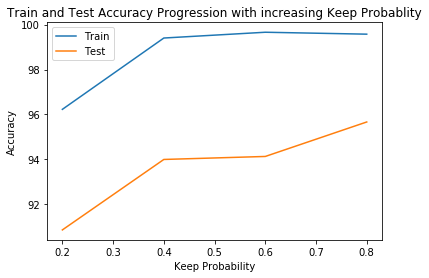

In [8]:
# Optimized Hyper Parameters
optimize(494, X_train_mat, y_train_mat, X_test_mat, y_test_mat, 0.01)